 # Laboratorium 11 - Spadek wzdłuż gradientu

In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import copy
from scipy.optimize import golden
from itertools import cycle


## Zadanie 1.

Rozwiąż ponownie problem predykcji typu nowotworu (laboratorium 2), używając metody spadku wzdłuż gradientu (ang. *gradient descent*). Stałą uczącą możesz wyznaczyć na podstawie najmniejszej i największej wartości własnej macierzy $A^T A$. Porównaj uzyskane rozwiązanie z metodą najmniejszych kwadratów, biorąc pod uwagę następujące kryteria:

* Dokładność predykcji na zbiorze testowym
* Teoretyczną złożoność obliczeniową
* Czas obliczeń.

In [2]:
labels = pd.read_csv("breast-cancer.labels", header=None, names=["name"])
column_names = labels["name"].tolist()


train_data = pd.read_csv("breast-cancer-train.dat", header=None, names=column_names)
validate_data = pd.read_csv(
    "breast-cancer-validate.dat", header=None, names=column_names
)


In [3]:
# Reprezentacja liniowa
A_train_linear = train_data.drop(["patient ID", "Malignant/Benign"], axis=1).values
A_validate_linear = validate_data.drop(
    ["patient ID", "Malignant/Benign"], axis=1
).values

# Reprezentacja kwadratowa
selected_features = [
    "radius (mean)",
    "perimeter (mean)",
    "area (mean)",
    "symmetry (mean)",
]


def create_quadratic_features(data):
    quadratic_features = data[selected_features].copy()
    for feature in selected_features:
        quadratic_features[f"{feature}^2"] = data[feature] ** 2
    for i in range(len(selected_features)):
        for j in range(i + 1, len(selected_features)):
            feature1 = selected_features[i]
            feature2 = selected_features[j]
            quadratic_features[f"{feature1}*{feature2}"] = (
                data[feature1] * data[feature2]
            )
    return quadratic_features.values


A_train_quadratic = create_quadratic_features(train_data)
A_validate_quadratic = create_quadratic_features(validate_data)


In [ ]:
# Wektor b dla zbioru treningowego
b_train = np.array(
    [[1, 0] if row == "M" else [0, 1] for row in train_data["Malignant/Benign"]]
)

# Wektor b dla zbioru walidacyjnego
b_validate = np.array(
    [[1, 0] if row == "M" else [0, 1] for row in validate_data["Malignant/Benign"]]
)


In [ ]:
def classify(W, X):
    S = X @ W
    return S == np.max(S, axis=1, keepdims=True)


In [ ]:
def calc_acc(P, T):
    accuracy = np.sum(P * T) / P.shape[0]
    return 100.0 * accuracy


def print_log(step, cost, train_acc, val_acc):
    log = (
        "Step {:3d}\tcost value: {:5.2f},\ttrain accuracy: {:5.2f},\t"
        "validation accuracy: {:5.2f}"
    )
    log = log.format(step, cost.item(), train_acc.item(), val_acc.item())

    print(log)


In [ ]:
def mse(S, T):
    return 0.5 * np.mean((S - T) ** 2)


def grad_mse(X, S, T):
    n = X.shape[0]
    return (1.0 / n) * X.T @ (S - T)


In [ ]:
def gd_fit(W0, X, T, X_val, T_val, lr=1.0, steps=100, log_every=5):
    n = X.shape[0]
    W = np.copy(W0)
    M = 0
    mu = 0.9

    stats = []

    for step in range(steps):
        S = X @ W
        cost_val = mse(S, T)

        cost_grad = grad_mse(X, S, T)
        M = mu * M - lr * cost_grad
        W = W + M

        P_train = classify(W, X)
        train_acc = calc_acc(P_train, T)

        P_val = classify(W, X_val)
        val_acc = calc_acc(P_val, T_val)

        stats.append((cost_val, train_acc, val_acc))
        if step == 0 or (step + 1) % log_every == 0:
            print_log(step + 1, cost_val, train_acc, val_acc)

    return W, stats


In [ ]:
ATA_eigenvalues, _ = np.linalg.eig(A_train_linear.T @ A_train_linear)
lambda_min = np.min(ATA_eigenvalues)
lambda_max = np.max(ATA_eigenvalues)
condition_no = lambda_max / lambda_min


In [10]:
X = np.column_stack([A_train_linear, np.full(A_train_linear.shape[0], 1)])
T = b_train
X_val = np.column_stack([A_validate_linear, np.full(A_validate_linear.shape[0], 1)])
T_val = b_validate

print(X.shape, T.shape, X_val.shape, T_val.shape)


(300, 31) (300, 2) (260, 31) (260, 2)


In [ ]:
# W0 = np.random.randn(31, 2)
W0 = np.zeros((31, 2))
# print(X)
# print(W0)
# print(softmax(X @ W0))


Learning rate:  3.667777291369401e-08
Step   1	cost value:  0.25,	train accuracy: 48.67,	validation accuracy: 23.08
Step  50	cost value:  0.13,	train accuracy: 48.67,	validation accuracy: 23.08
Step 100	cost value:  0.12,	train accuracy: 48.67,	validation accuracy: 23.46
Step 150	cost value:  0.12,	train accuracy: 56.67,	validation accuracy: 31.92
Step 200	cost value:  0.11,	train accuracy: 73.33,	validation accuracy: 56.92
Step 250	cost value:  0.11,	train accuracy: 81.67,	validation accuracy: 68.08
Step 300	cost value:  0.11,	train accuracy: 86.00,	validation accuracy: 76.54
Step 350	cost value:  0.11,	train accuracy: 90.00,	validation accuracy: 80.38
Step 400	cost value:  0.10,	train accuracy: 92.00,	validation accuracy: 85.38
Step 450	cost value:  0.10,	train accuracy: 91.67,	validation accuracy: 87.69
Step 500	cost value:  0.10,	train accuracy: 92.00,	validation accuracy: 90.00
Step 550	cost value:  0.10,	train accuracy: 92.00,	validation accuracy: 91.15
Step 600	cost value:  0.10

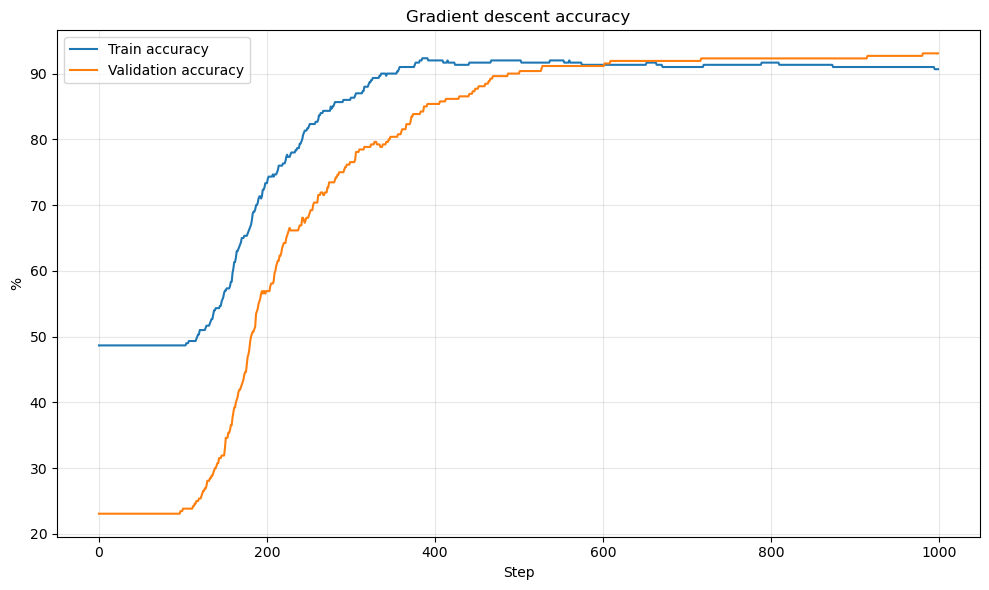

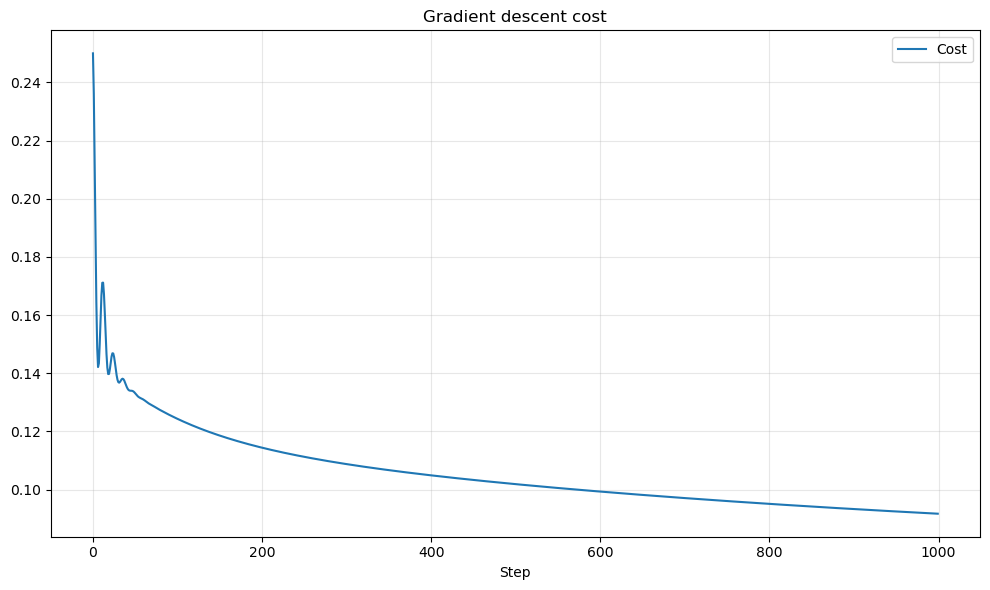

In [12]:
# Another try with higher learning rate
lr = 20 / (lambda_max)

print("Learning rate: ", lr)
W, stats = gd_fit(W0, X, T, X_val, T_val, lr=lr, steps=1000, log_every=50)


cost = [t[0] for t in stats]
t_acc = [t[1] for t in stats]
v_acc = [t[2] for t in stats]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each series
plt.plot(t_acc, label="Train accuracy")
plt.plot(v_acc, label="Validation accuracy")

# Customize the plot
plt.xlabel("Step")
plt.ylabel("%")
plt.title("Gradient descent accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()


# Create the plot
plt.figure(figsize=(10, 6))

# Plot each series
plt.plot(cost, label="Cost")

# Customize the plot
plt.xlabel("Step")
plt.title("Gradient descent cost")
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

## Zadanie 2.

Należy wyznaczyć najkrótszą ścieżkę robota pomiędzy dwoma punktami $x^{(0)}$ i $x^{(n)}$. Problemem są przeszkody usytuowane na trasie robota, których należy unikać. Zadanie polega na minimalizacji funkcji kosztu, która sprowadza problem nieliniowej optymalizacji z ograniczeniami do problemu nieograniczonego optymalizacji.

Macierz $X \in \mathbb{R}^{(n+1) \times 2}$ opisuje ścieżkę złożoną z $n+1$ punktów $x^{(0)}, x^{(1)}, x^{(2)}, \ldots, x^{(n)}$. Każdy punkt $x^{(i)} \in \mathbb{R}^2$. Punkty początkowy i końcowy ścieżki, $x^{(0)}$ i $x^{(n)}$, są ustalone.

Punkty z przeszkodami (punkty o 2 współrzędnych), $r^{(j)}$ dane są w macierzy przeszkód $R \in \mathbb{R}^{k \times 2}$.

W celu optymalizacji ścieżki robota należy użyć metody największego spadku. Funkcja celu użyta do optymalizacji $F(x^{(0)}, x^{(1)}, \ldots, x^{(n)})$ zdefiniowana jest jako:

$$F(x^{(0)}, x^{(1)}, \ldots, x^{(n)}) = \lambda_1 \sum_{i=0}^{n} \sum_{j=1}^{k} \frac{1}{\epsilon + \|x^{(i)} - r^{(j)}\|^2} + \lambda_2 \sum_{i=0}^{n-1} \|x^{(i+1)} - x^{(i)}\|^2$$

Symbole użyte we wzorze mają następujące znaczenie:

* Stałe $\lambda_1$ i $\lambda_2$ określają wpływ każdego członu wyrażenia na wartość $F(X)$.
    * $\lambda_1$ określa wagę składnika zapobiegającego zbytniemu zbliżaniu się do przeszkody
    * $\lambda_2$ określa wagę składnika zapobiegającego tworzeniu bardzo długich ścieżek

* $n$ jest liczbą odcinków, a $n+1$ liczbą punktów na trasie robota.
* $k$ jest liczbą przeszkód, których robot musi unikać.
* Dodanie $\epsilon$ w mianowniku zapobiega dzieleniu przez zero.

1.  Wyprowadź wyrażenie na gradient $\nabla F$ funkcji celu $F$ względem $x^{(i)}$:
    $\nabla F = \left[ \frac{\partial F}{\partial x^{(0)}}, \ldots, \frac{\partial F}{\partial x^{(n)}} \right]$.
    Wzór wyraź poprzez wektory $x^{(i)}$ i ich składowe, wektory $r^{(j)}$ i ich składowe, $\epsilon, \lambda_1, \lambda_2, n$ i $k$ (niekoniecznie wszystkie).
    Wskazówka. $\frac{\partial \|z\|^2}{\partial z} = 2z$.

2.  Opisz matematycznie i zaimplementuj kroki algorytmu największego spadku z przeszukiwaniem liniowym, który służy do minimalizacji funkcji celu $F$. Do przeszukiwania liniowego (ang. *line search*) użyj metody złotego podziału (ang. *golden section search*). W tym celu załóż, że $F$ jest unimodalna (w rzeczywistości tak nie jest) i że można ustalić początkowy przedział, w którym znajduje się minimum.

3.  Znajdź najkrótszą ścieżkę robota przy użyciu algorytmu zaimplementowanego w w poprzednim punkcie. Przyjmij następujące wartości parametrów:
    * $n = 20, k = 50$
    * $x^{(0)} = [0, 0]$, $x^{(n)} = [20, 20]$
    * $r^{(j)} \sim \mathcal{U}(0, 20) \times \mathcal{U}(0, 20)$
    * $\lambda_1 = \lambda_2 = 1$
    * $\epsilon = 10^{-13}$
    * liczba iteracji = 400

Ponieważ nie chcemy zmieniać położenia punktu początkowego i końcowego, $x^{(0)}, x^{(n)}$, wyzeruj gradient funkcji $F$ względem tych punktów.

Obliczenia przeprowadź dla 5 różnych losowych inicjalizacji punktów wewnątrz ścieżki $x^{(1)}, \ldots, x^{(n-1)}$.

Narysuj przykładowy wykres wartości funkcji $F$ w zależności od iteracji.

Zapewnij powtarzalność wyników, ustawiając wartość odpowiedniego ziarna.

 ![signal-2025-06-17-152231_002.jpeg](attachment:signal-2025-06-17-152231_002.jpeg)

In [ ]:
np.random.seed(1234)

n = 20
k = 50
x_0 = [0, 0]
x_n = [20, 20]
R = np.random.uniform(0, 20, (k, 2))
l_1 = l_2 = 1.0
eps = 10e-13
iterations = 400


In [ ]:
def cost(X):
    # Pierwszy składnik - unikanie przeszkód
    A = 0
    for i in range(n + 1):
        for j in range(k):
            A += 1 / (eps + np.linalg.norm(X[i] - R[j]) ** 2)

    # Drugi składnik - minimalizacja długości ścieżki
    B = 0
    for i in range(n):
        B += np.linalg.norm(X[i + 1] - X[i]) ** 2

    return l_1 * A + l_2 * B


In [ ]:
def grad_cost(X):
    gradient = np.zeros_like(X)

    # Gradient dla punktów środkowych (1 do n-1)
    for i in range(1, n):
        # Składnik od przeszkód
        for j in range(k):
            diff = X[i] - R[j]
            norm_sq = np.linalg.norm(diff) ** 2
            gradient[i] += -2 * l_1 * diff / (eps + norm_sq) ** 2

        # Składnik od długości ścieżki
        gradient[i] += (
            -2 * l_2 * (X[i + 1] - X[i])
        )  # pochodna względem x[i] z ||x[i+1] - x[i]||^2
        gradient[i] += (
            2 * l_2 * (X[i] - X[i - 1])
        )  # pochodna względem x[i] z ||x[i] - x[i-1]||^2

    # Gradient dla punktów końcowych jest zerowy (stałe)
    gradient[0] = 0
    gradient[-1] = 0

    return gradient


In [ ]:
def line_search(X):
    costs = []
    copyX = copy.deepcopy(X)

    def helper(xs, grad):
        return lambda alpha: cost(xs + alpha * grad)

    for i in range(iterations):
        costs.append(cost(copyX))
        grad = grad_cost(copyX)

        alpha = golden(helper(copyX, -grad))

        print(
            f"Step: {i}, Alpha: {alpha}, Cost: {cost(copyX)}, Grad Norm: {np.linalg.norm(grad)}"
        )

        copyX += alpha * (-grad)

        if i > 0 and abs(costs[-1] - costs[-2]) < eps:
            break

    return (copyX, costs)


In [17]:
XS = []
costs = []
results = []

for i in range(5):
    X = np.vstack((x_0, np.random.uniform(0, 20, (n - 1, 2)), x_n))

    XS.append(X)

    (result, res_cost) = line_search(X)
    results.append(result)
    costs.append(res_cost)

    next_seed = np.random.randint(0, 1000)
    np.random.seed(next_seed)


Step: 0, Alpha: 0.1554356956676077, Cost: 3657.9641724124094, Grad Norm: 190.35598453303277
Step: 1, Alpha: 0.23964356684285298, Cost: 838.1289590310109, Grad Norm: 60.06807620469373
Step: 2, Alpha: 0.13468831629162187, Cost: 422.6934271001221, Grad Norm: 42.54213538777271
Step: 3, Alpha: 0.07241386729230581, Cost: 310.51519223170385, Grad Norm: 31.91569092174007
Step: 4, Alpha: 0.2614009866148298, Cost: 287.6721103226887, Grad Norm: 19.08563642365163
Step: 5, Alpha: 0.03676933427294825, Cost: 235.89256879703592, Grad Norm: 46.38804580913859
Step: 6, Alpha: 0.2765205741925206, Cost: 222.73031605300707, Grad Norm: 13.744832190172508
Step: 7, Alpha: 0.13576742771925243, Cost: 196.9439574284168, Grad Norm: 13.259099550318453
Step: 8, Alpha: 0.054340735857330194, Cost: 184.96075702833946, Grad Norm: 15.201632965649067
Step: 9, Alpha: 0.42683579176594455, Cost: 181.27867945984738, Grad Norm: 7.226176265738932
Step: 10, Alpha: 0.08911127243794262, Cost: 171.16549995779602, Grad Norm: 10.3971

In [ ]:
print("Koszty końcowe dla każdej próby:")
for i, cost_history in enumerate(costs):
    print(f"Próba {i + 1}: {cost_history[-1]:.6f}")


Koszty końcowe dla każdej próby:
Próba 1: 70.139501
Próba 2: 75.080737
Próba 3: 69.062293
Próba 4: 69.951910
Próba 5: 74.477471


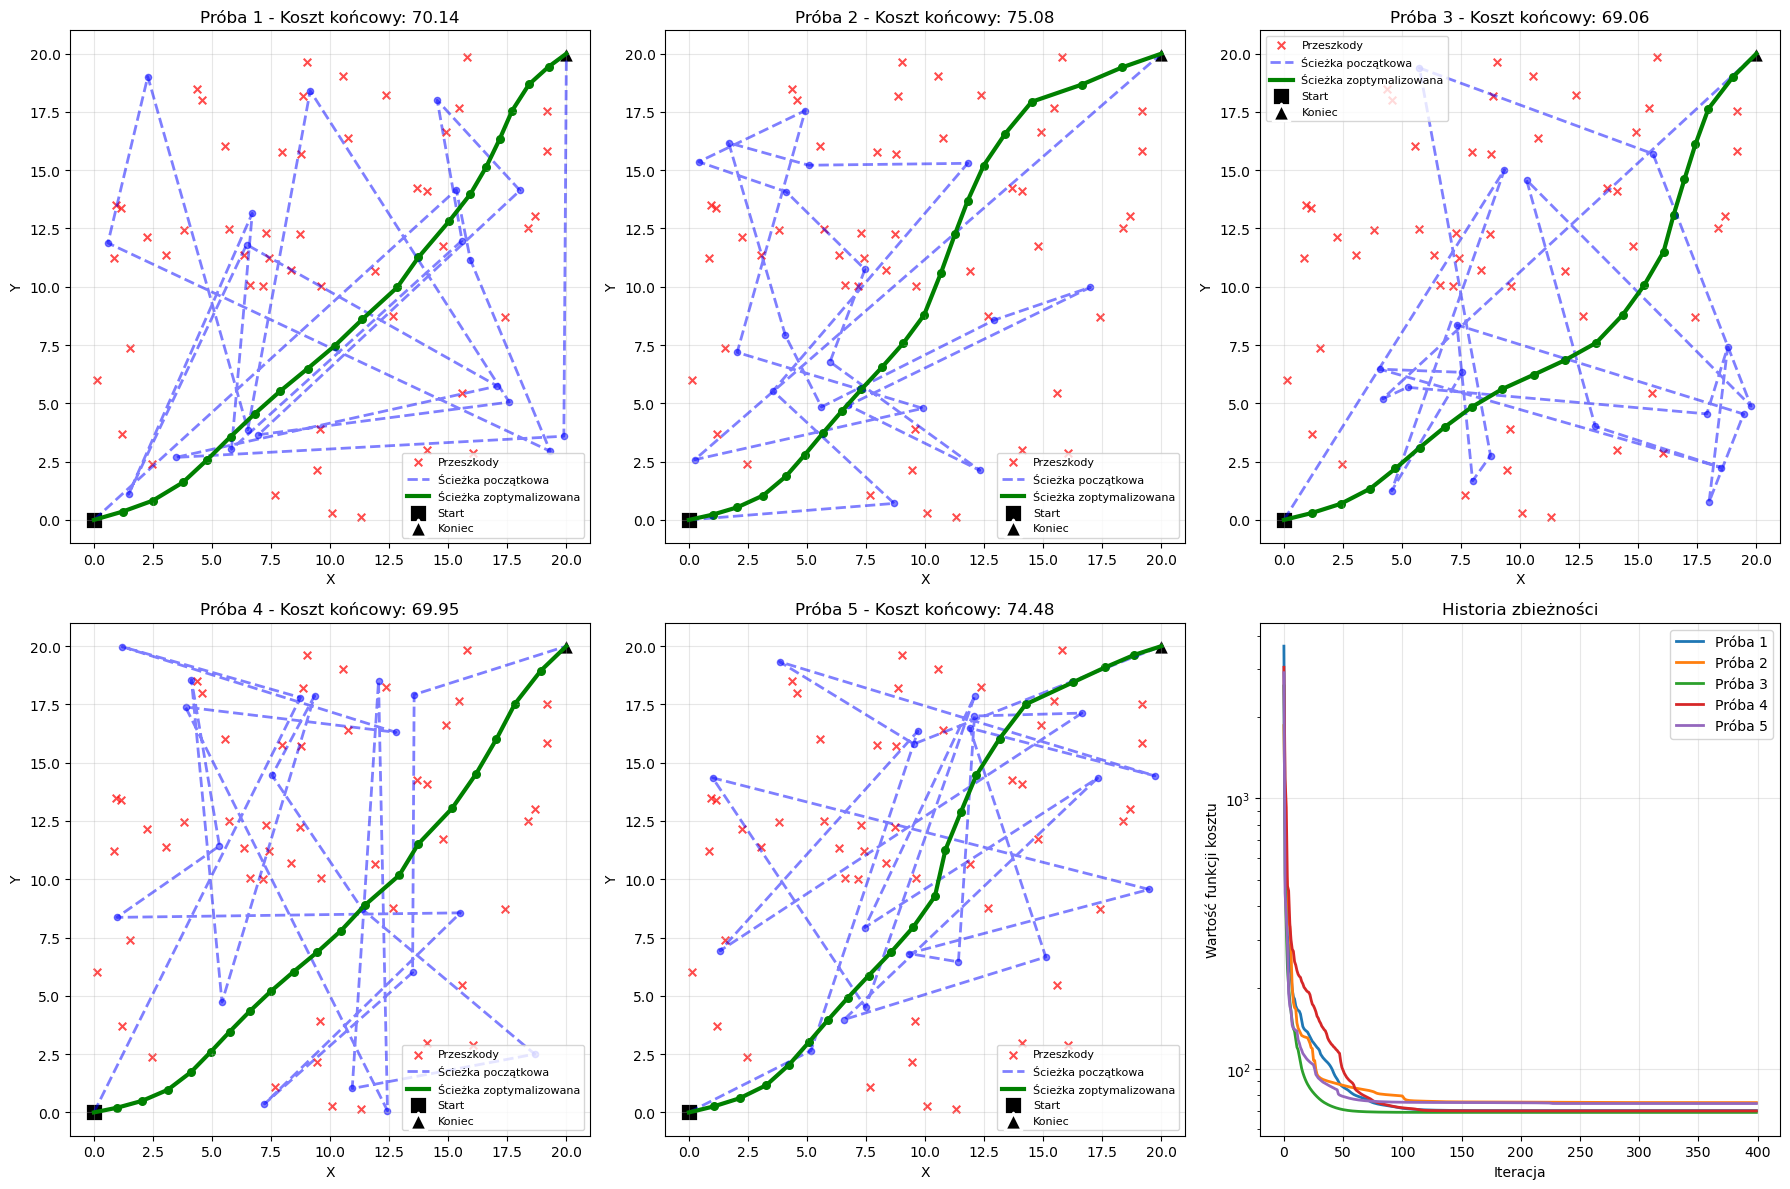

In [ ]:
def plot_robot_paths():
    """Rysuje ścieżki robota z wszystkich 5 prób"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    axes_flat = axes.flatten()

    for i in range(5):
        ax = axes_flat[i]

        ax.scatter(
            R[:, 0], R[:, 1], c="red", s=30, alpha=0.7, marker="x", label="Przeszkody"
        )

        initial_path = XS[i]
        ax.plot(
            initial_path[:, 0],
            initial_path[:, 1],
            "b--",
            alpha=0.5,
            linewidth=2,
            label="Ścieżka początkowa",
        )
        ax.scatter(initial_path[:, 0], initial_path[:, 1], c="blue", s=20, alpha=0.5)

        optimized_path = results[i]
        ax.plot(
            optimized_path[:, 0],
            optimized_path[:, 1],
            "g-",
            linewidth=3,
            label="Ścieżka zoptymalizowana",
        )
        ax.scatter(optimized_path[:, 0], optimized_path[:, 1], c="green", s=30)

        ax.scatter(
            *x_0,
            c="black",
            s=150,
            marker="s",
            label="Start",
            edgecolors="white",
            linewidth=2,
        )
        ax.scatter(
            *x_n,
            c="black",
            s=150,
            marker="^",
            label="Koniec",
            edgecolors="white",
            linewidth=2,
        )

        ax.set_xlim(-1, 21)
        ax.set_ylim(-1, 21)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        ax.set_title(f"Próba {i + 1} - Koszt końcowy: {costs[i][-1]:.2f}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")

    ax = axes_flat[5]
    for i, cost_history in enumerate(costs):
        ax.plot(cost_history, label=f"Próba {i + 1}", linewidth=2)

    ax.set_xlabel("Iteracja")
    ax.set_ylabel("Wartość funkcji kosztu")
    ax.set_title("Historia zbieżności")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale("log")

    plt.tight_layout()
    plt.show()


plot_robot_paths()


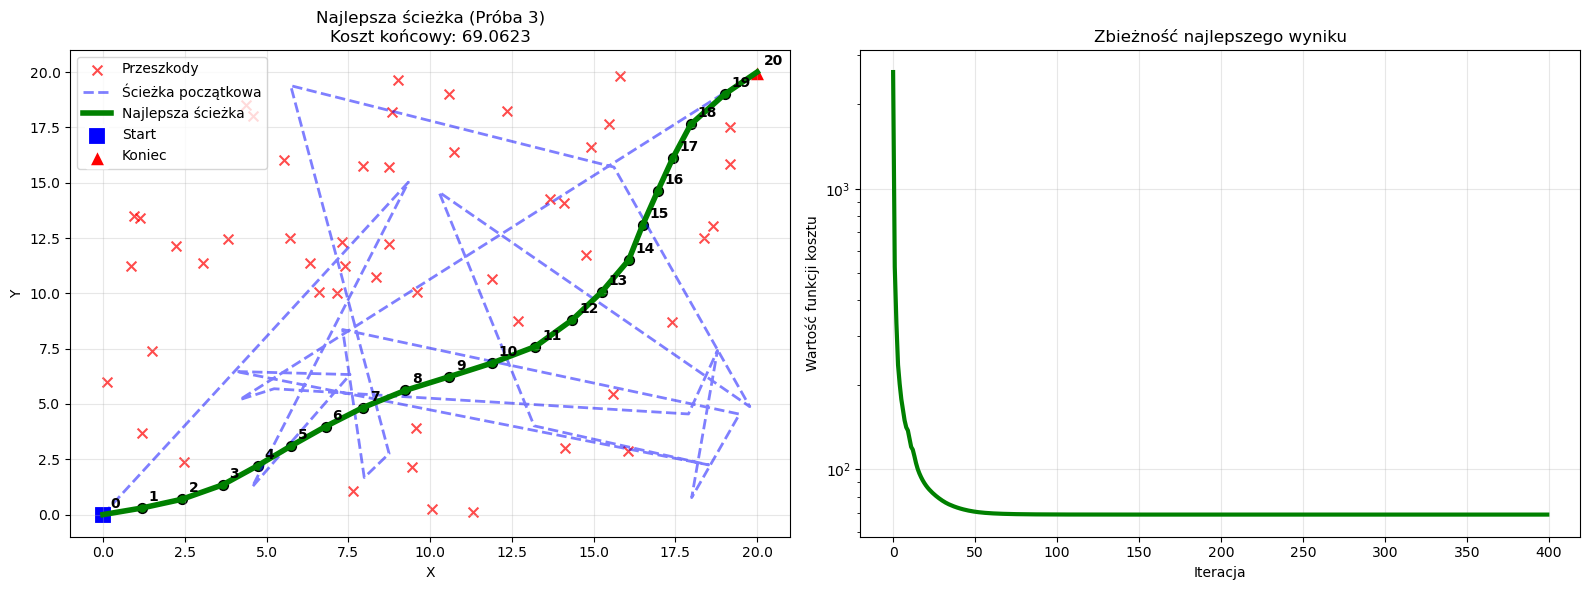

Najlepszy wynik z próby 3
Koszt końcowy: 69.062293
Liczba iteracji: 400


In [ ]:
def plot_best_result():
    """Rysuje najlepszy wynik z większymi szczegółami"""

    final_costs = [cost_history[-1] for cost_history in costs]
    best_idx = np.argmin(final_costs)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.scatter(
        R[:, 0], R[:, 1], c="red", s=50, alpha=0.7, marker="x", label="Przeszkody"
    )

    initial_path = XS[best_idx]
    ax1.plot(
        initial_path[:, 0],
        initial_path[:, 1],
        "b--",
        alpha=0.5,
        linewidth=2,
        label="Ścieżka początkowa",
    )

    best_path = results[best_idx]
    ax1.plot(
        best_path[:, 0], best_path[:, 1], "g-", linewidth=4, label="Najlepsza ścieżka"
    )
    ax1.scatter(
        best_path[:, 0],
        best_path[:, 1],
        c="green",
        s=50,
        edgecolors="black",
        linewidth=1,
    )

    for i, point in enumerate(best_path):
        ax1.annotate(
            str(i),
            (point[0], point[1]),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=10,
            fontweight="bold",
        )

    ax1.scatter(
        *x_0,
        c="blue",
        s=200,
        marker="s",
        label="Start",
        edgecolors="white",
        linewidth=3,
    )
    ax1.scatter(
        *x_n,
        c="red",
        s=200,
        marker="^",
        label="Koniec",
        edgecolors="white",
        linewidth=3,
    )

    ax1.set_xlim(-1, 21)
    ax1.set_ylim(-1, 21)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_title(
        f"Najlepsza ścieżka (Próba {best_idx + 1})\nKoszt końcowy: {final_costs[best_idx]:.4f}"
    )
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")

    ax2.plot(costs[best_idx], "g-", linewidth=3)
    ax2.set_xlabel("Iteracja")
    ax2.set_ylabel("Wartość funkcji kosztu")
    ax2.set_title(f"Zbieżność najlepszego wyniku")
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale("log")

    plt.tight_layout()
    plt.show()

    print(f"Najlepszy wynik z próby {best_idx + 1}")
    print(f"Koszt końcowy: {final_costs[best_idx]:.6f}")
    print(f"Liczba iteracji: {len(costs[best_idx])}")


plot_best_result()
